# Business Data Analytics - Exercise Classification Tutorial

This notebook is designed to illustrate basic machine learning techniques. The focus hereby lies on classification problems. We will first look at a simple binary classifcation problem and learn how sampling can increase classification performance. Then, we will explore a multilabel classification problem and learn how this problem is different from a classification problem.


## Binary classifcation 

In this section, we will use the [LFW (Faces in the Wild) dataset](http://vis-www.cs.umass.edu/lfw/) and try to predict if the picture either shows B. Clinton or G.W. Bush. 

In [5]:
# import necessary libraries
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn import FunctionSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline

In [6]:
data = fetch_lfw_people()
george_bush_id = 1871  # Photos of George W. Bush
bill_clinton_id = 531  # Photos of Bill Clinton
classes = [george_bush_id, bill_clinton_id]
classes_name = np.array(["B. Clinton", "G.W. Bush"], dtype=object)

In [7]:
mask_photos = np.isin(data.target, classes)
X, y = data.data[mask_photos], data.target[mask_photos]
y = (y == bill_clinton_id).astype(np.int8)

The positive label considered as the minority class is 1


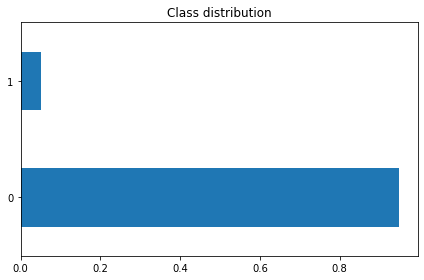

In [8]:
class_distribution = pd.Series(y).value_counts(normalize=True)
ax = class_distribution.plot.barh()
ax.set_title("Class distribution")
pos_label = class_distribution.idxmin()
plt.tight_layout()
print(f"The positive label considered as the minority class is {pos_label}")

#### Task: Training a machine learning algorithm to solve a binary classification problem

Please consider the following constraints:
- To get better estimations of the true performance, use at least a 3 fold cross validation strategy.
- Evaluate the same classifier for different scenarios on the Area Under the Curve (AUC)
    - No sampling technique
    - Random over sampling of the minority class
    - Use a sampling technique called SMOTE
- Plot the Receiver Operating Characteristic for all three scenarios

To get started with cross validation techniques, please read [sklearn's guide](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation). **Which cross validation strategy is particulary suited for this task?** The [imblearn library](https://imbalanced-learn.org/stable/) provides a good overview of different sampling techniques and should help you with your task. **What is a possible disadvantage of the over sampling methods?** 



Use the cells below to answer this question

#### Task: Plot the probability distribution for varying under sampling thresholds using random under sampling

What happens to the distributions? How do they change?

Use the cell below for your answer. 

## Multilabel classification

In this section, we will be using the dataset from the jigsaw toxic comment classification challenge on Kaggle. The goal is to assign each text labels, that represent the kind of toxity. Possible labels include:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

We will treat this problem as a multilabel classification problem. The difference between multiclass classification & multilabel classification is that in multiclass problems the classes are mutually exclusive, whereas for multilabel problems each label represents a different classification task, but the tasks are somehow related.

Click [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) to read more about the challenge. The code of this notebook is inspired by [this blogpost](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff) from Kartik Nooney on towardsdatascience.com



In [15]:
# import packages
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB

from skmultilearn.problem_transform import BinaryRelevance

### Exploratory Data Analysis (EDA)

First, we will load the data and then plot the distribution of our target variable.

In [16]:
data = pd.read_csv("data.csv")

print("Number of rows in data:", data.shape[0])
print("Number of columns in data:", data.shape[1])
print("**Sample data:**")
data.head()

Number of rows in data: 159571
Number of columns in data: 8
**Sample data:**


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [17]:
# drop ID
data.drop(['id'], axis=1, inplace=True)

c:\users\di872\desktop\lehre\bda\ss2022\übung\exercises\02_classififcation\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


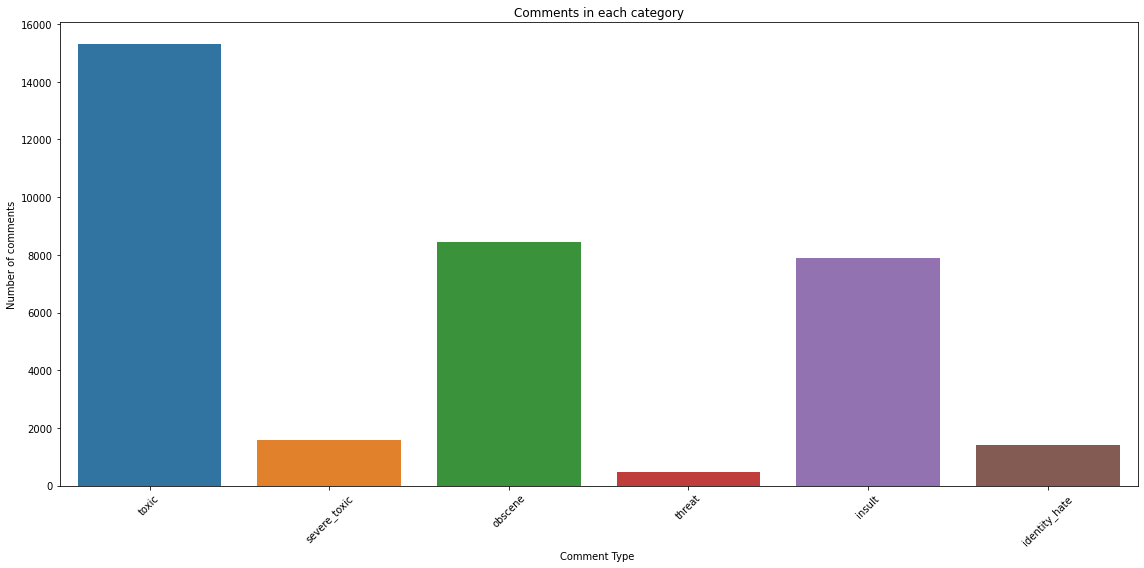

In [19]:
categories = list(data.drop(['comment_text'], axis=1).columns.values)
plt.figure(figsize=(16,8))
ax= sns.barplot(categories, data.iloc[:,1:].sum().values)
plt.title("Comments in each category")
plt.ylabel('Number of comments')
plt.xlabel('Comment Type ')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Task: Plot the number of texts with multiple labels

Use the cell below for your answer

### Preprocessing

Now, we want to preprocess our text data to remove noise in our dataset and make it easier for our machine learning model to learn patterns. Possible steps include:
- Transform text to lower case
- Remove html annotations
- Remove punctuation
- Remove non-alphabetic characters
- Remove stop words
- Apply stemming

#### Task: Implement a preprocessing pipeline with the above mentioned steps

A useful library for removing any sort of patterns from a text is the [re](https://docs.python.org/3/library/re.html) library for regular expressions. More advanced text preprocessing techniques, such as stemming and lemmatization, can be accessed through the [spacy](https://spacy.io/) or [nltk](https://www.nltk.org/) library. We have already installed the nltk library. If you want to use spacy, you need to install its library first.

Use the cell below for your answer.

### Modelling 

With the cleaned data, we are one step closer to applying a machine learning model. But before we do so, we will need to split our data into a training and testing set.

Use the cell below for your answer.

In [ ]:
texts, labels = data['comment_text'], data.drop(['comment_text'], axis=1)
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, random_state=42, test_size=0.30, shuffle=True)

Now we can transform our text data into a vector representation using the term frequency inverse document frequency (TFIDF) methodology.

#### Task: Apply TFIDF to our text data

Use the cell below for your answer.

#### Task: Multilabel classification

Most traditional learning algorithms are developed for single-label classification problems. Therefore a lot of approaches in the literature transform the multi-label problem into multiple single-label problems, so that the existing single-label algorithms can be used. In our case, we want to train multiple binary classifiers that predict if a text contains a certain label. If you want to read more about other classifcation techniques for multilabel problems, click [here](http://scikit.ml/). 

Use the cell below for your answer.

#### Task: Evaluation

Evaluate your results by looking at the overall accuracy and the precision, recall and f1 score for each label.

Use the cell below for your answer.